## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6567, val loss 2.6668
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4198, val loss 2.4337
step 400: train loss 2.3507, val loss 2.3568
step 500: train loss 2.2967, val loss 2.3133
step 600: train loss 2.2413, val loss 2.2503
step 700: train loss 2.2051, val loss 2.2187
step 800: train loss 2.1640, val loss 2.1873
step 900: train loss 2.1234, val loss 2.1500
step 1000: train loss 2.1028, val loss 2.1298
step 1100: train loss 2.0701, val loss 2.1194
step 1200: train loss 2.0384, val loss 2.0799
step 1300: train loss 2.0252, val loss 2.0641
step 1400: train loss 1.9934, val loss 2.0380
step 1500: train loss 1.9690, val loss 2.0299
step 1600: train loss 1.9637, val loss 2.0485
step 1700: train loss 1.9440, val loss 2.0149
step 1800: train loss 1.9075, val loss 1.9937
step 1900: train loss 1.9122, val loss 1.9900
step 2000: train loss 1.8858, val loss 1.9958
step 2100: train loss 1.

# MD3 University of Latvia starts here
### Full finished code from Karpathy video has not learned the training set yet, see Top1 generation:

Even if we would train this code for 30,000 iterations, it would still not be able to complete correctly the fragment from the training set 

*Is she a Capulet?*

*O dear account! my life is my foe's debt.*

In [2]:
model.eval()

def generateTop(model, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = model.forward(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            #idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#ROMEO:
#Is she a Capulet?
#O dear account! my life is my foe's debt.
context = torch.tensor(encode("Is she a Capulet?"), dtype=torch.long).unsqueeze(0).to(device)

print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))

#model.train()

+++  Is she a Capulet?

KING RICHARD II:
What the stray the straight the straight the straight the straight the straight t
+++  Is she a Capulet?

KING RICHARD II:
What the stray the straight the straight the straight the straight the straight t
+++  Is she a Capulet?

KING RICHARD II:
What the stray the straight the straight the straight the straight the straight t


### MD3: To fix the problem, we  increase the number of parameters and train for 30,000 iterations

Here use of GPU is essential. Even with GPU it takes about 1 hour. Now the model has correctly memorized the training set, but is overfitting on the validation data, as is visible in the loss graph.

--2024-04-08 11:08:56--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.4’

input.txt.4         100%[===================>]   1.06M  5.91MB/s    in 0.2s    

2024-04-08 11:08:57 (5.91 MB/s) - ‘input.txt.4’ saved [1115394/1115394]

6.353985 M parameters
step 0: train loss 4.3298, val loss 4.3267 (perplexity 75.69 / 65 = 116.45% uncertainty)
step 100: train loss 2.1404, val loss 2.1672 (perplexity 8.73 / 65 = 13.44% uncertainty)
step 200: train loss 1.7920, val loss 1.9223 (perplexity 6.84 / 65 = 10.52% uncertainty)
step 300: train loss 1.6232, val loss 1.7953 (perplexity 6.02 / 65 = 9.26% uncertainty)
step 400: train loss

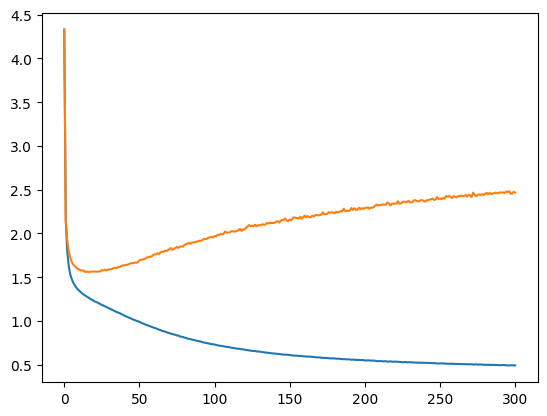


You have lost along, and with
sighs friends as e'er was heard of.
I happy side, and crave the hires:'
When he, and that will pieces she mammock'd
The strange thereof, they call the water for my queen:
How, dame Pritop to toward my Paris,
A most fall of behalf as the silk, the heart of an Edward's;
And now forthwith shall article.

KING RICHARD II:
The best of it all on yourself.

AUFIDIUS:
Remember you a wife: love it.

ESCALUS:
Go on before; the more, ariser way,
Here I mock'd with a tale soft should be silent, and
cause me but according to the
drivers-ingher than they or say no.

MENENIUS:
Sir, you shall bear your face.

LUCIO:
More than poison, I think, is it so.

ESCALUS:
How art thou that dost of which heavily for a need.
I prithee, chase thee, presently in performer grudgined York.

LEONTES:
But mistaker, that I may contrive to talk
on whom them, and we will not choose but hat
A dream of what thou art, and lest in Rome. Fifth, so were I read,
And therefore prinves no joy to stri

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt

# hyperparameters
batch_size = 512 # 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 30000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256 # 64
n_head = 4
n_layer = 8
dropout = 0.1
# ------------

torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
#wget http://www.ltn.lv/~guntis/translation_dataset/dataset_lv_small.txt
with open('input.txt', 'r', encoding='utf-8') as f:
#with open('dataset_lv_small.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

loss_values = []  # List to store loss values

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        #print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f} (perplexity {1/(math.exp(-1*losses['val'])):.2f} / {vocab_size} = {(1/(math.exp(-1*losses['val'])))/(vocab_size/100):.2f}% uncertainty)")
        loss_values.append([losses['train'],losses['val']])  # Store averaged loss value
        torch.save(model.state_dict(), f"checkpoint_{iter}.pt")
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plot the training loss
plt.plot(loss_values, label='Training Loss')
plt.show()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

# Learning training data
#ROMEO:
#Is she a Capulet?
#O dear account! my life is my foe's debt.
context = torch.tensor(encode("Is she a Capulet?"), dtype=torch.long).unsqueeze(0).to(device)
print("--- ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("--- ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("--- ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))

model.eval() # This disables dropout

context = torch.tensor(encode("Is she a Capulet?"), dtype=torch.long).unsqueeze(0).to(device)
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))

def generateTop(model, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = model.forward(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            #idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))

#model.train()

### MD3: From the checpoint at 15,000 iterations we see that the training set was not yet memorized

In [4]:
model.load_state_dict(torch.load( f"checkpoint_15000.pt"))


model.eval()

# generate from the model
#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#ROMEO:
#Is she a Capulet?
#O dear account! my life is my foe's debt.
context = torch.tensor(encode("Is she a Capulet?"), dtype=torch.long).unsqueeze(0).to(device)
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print("*** ", decode(m.generate(context, max_new_tokens=100)[0].tolist()))

def generateTop(model, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = model.forward(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            #idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))
print("+++ ", decode(generateTop(model,context, max_new_tokens=100)[0].tolist()))

#model.train()

***  Is she a Capulet?
O dear account! madam! madam! these good houses!
Come, Hastings, and Edward, Sir York
Will we chang
***  Is she a Capulet?
O dear account! my life is shed
To be a vulgar than thus; 'tis a sore throughly cheatly swear to st
***  Is she a Capulet?
O dear account! might have my life,
That ne'er you have touch'd his spirit
And made them forth, and
***  Is she a Capulet?
O gods have I the continuance of the queen,
Be he'll play the orator.

MONTAGUE:
Why, then, give wa
***  Is she a Capulet?
O dear account! my dukedom, throne and kites at his feather from the firmament,
And sorted as her m
+++  Is she a Capulet?
O dear account! my dukedom, throne and kingdom say;
Either that is too cold in thine eye
Than twent
+++  Is she a Capulet?
O dear account! my dukedom, throne and kingdom say;
Either that is too cold in thine eye
Than twent
+++  Is she a Capulet?
O dear account! my dukedom, throne and kingdom say;
Either that is too cold in thine eye
Than twent
+++  Is she a Ca

### MD3: Here we generate text from any prompt

It is not yet a ChatGPT, because it is not yet fine-tuned on the Instruction dataset containing Questions and Answer pairs

In [7]:
! wget https://github.com/guntisx/DeepLearningCourse/raw/main/MD3/checkpoint_29999.pt

model.load_state_dict(torch.load( f"checkpoint_29999.pt"))
model.eval()
    
def generate_with_prompt(prompt, max_new_tokens):
    prompt_encoded = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(device)
    generated = model.generate(prompt_encoded, max_new_tokens=max_new_tokens)
    generated_text = decode(generated.squeeze().tolist())
    return generated_text

while True:
    prompt = input("Ievadi promtu vai q, lai pabeigtu sarunu: ")
    if prompt.lower() == 'q':
        break

    generated_text = generate_with_prompt(prompt, max_new_tokens=50)
    print(generated_text)
    print("-----------")
    

--2024-04-08 13:09:19--  https://github.com/guntisx/DeepLearningCourse/raw/main/MD3/checkpoint_29999.pt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/guntisx/DeepLearningCourse/main/MD3/checkpoint_29999.pt [following]
--2024-04-08 13:09:20--  https://raw.githubusercontent.com/guntisx/DeepLearningCourse/main/MD3/checkpoint_29999.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25626005 (24M) [application/octet-stream]
Saving to: ‘checkpoint_29999.pt’

checkpoint_29999.pt 100%[===================>]  24.44M  35.2MB/s    in 0.7s    

2024-04-08 13:09:22 (35.2 MB/s) - ‘checkpoint_29999.pt’ saved 